In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(1)
np.random.seed(1)

sns.set_style("whitegrid")

In [2]:
def generate_data(num_samples=100):
    # Parameters for first Gaussian blob
    mean1 = [2.0, 3.0]
    cov1 = [[1.0, 0.3], [0.3, 0.5]]

    # Parameters for second Gaussian blob
    mean2 = [-1.0, -2.0]
    cov2 = [[0.4, -0.1], [-0.1, 0.3]]

    # Parameters for third Gaussian blob
    mean3 = [4.0, -1.0]
    cov3 = [[0.3, 0.2], [0.2, 0.5]]

    # Parameters for fourth Gaussian blob
    mean4 = [-3.0, 2.0]
    cov4 = [[0.5, -0.2], [-0.2, 0.3]]

    # Generate data points
    data1 = np.random.multivariate_normal(mean1, cov1, num_samples // 4)
    data2 = np.random.multivariate_normal(mean2, cov2, num_samples // 4)
    data3 = np.random.multivariate_normal(mean3, cov3, num_samples // 4)
    data4 = np.random.multivariate_normal(mean4, cov4, num_samples // 4)
    data = np.vstack([data1, data2, data3, data4])

    return torch.tensor(data, dtype=torch.float32)

In [3]:
from simple_einet.einet import Einet, EinetConfig
from simple_einet.layers.distributions.normal import Normal
from EinetCE import EinetCardEstConfig, EinetCardinalityEstimator

In [4]:
from tqdm import tqdm

def generate_query():
    l1, l2, u1, u2 = np.random.rand(4) * 8 - 4
    if l1 > u1:
        l1, u1 = u1, l1
    if l2 > u2:
        l2, u2 = u2, l2 
    return torch.Tensor([[l1, u1], [l2, u2]])

def calc_qerr(est, GT, epsilon = 10):
    if GT < epsilon:
        GT = epsilon
    if est < epsilon:
        est = epsilon
    return max(GT / est, est / GT)

def perform_query(points, query):
    ll, ur = query.squeeze().unbind(-1)
    l1, l2 = ll.tolist()
    u1, u2 = ur.tolist()
    cnt = 0
    for pt in points:
        if l1 <= pt[0] and pt[0] <= u1 and l2 <= pt[1] and pt[1] <= u2:
            cnt += 1
    if cnt < 10:
        cnt = 10
    return cnt

def experiment_counting(data, model: EinetCardinalityEstimator, n_runs, epsilon = 10):
    gmq = 0
    for i in tqdm(range(n_runs)):
        while True:
            query = generate_query()
            GT = perform_query(data, query)
            if (GT > 10):
                break
        est = model.query(query)
        q_err = calc_qerr(est, GT, epsilon)
        gmq += np.log(q_err)
    return np.exp(gmq / n_runs)

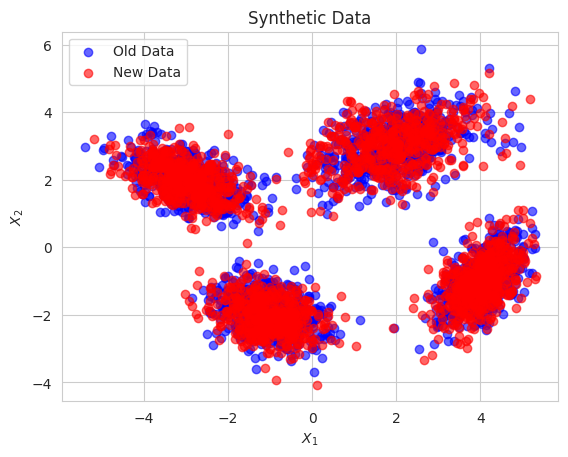

In [5]:
num_datasamples = 4000
old_data = generate_data(num_datasamples // 2)
new_data = generate_data(num_datasamples // 2)
full_data = torch.cat((old_data, new_data), 0)

plt.title("Synthetic Data")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.scatter(old_data[:, 0], old_data[:, 1], alpha=0.6, color="blue", label = "Old Data")
plt.scatter(new_data[:, 0], new_data[:, 1], alpha=0.6, color="red", label = "New Data")
plt.legend()
plt.show()

In [6]:
model_cfg = EinetConfig(
    num_features=2,
    num_channels=1,
    num_sums=4,
    num_leaves=4,
    num_repetitions=4,
    num_classes=1,
    depth=1,
    dropout=0.0,
    leaf_type=Normal,
    layer_type="einsum"
)

In [7]:
def train(data, model, epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    loss_log = []

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        log_prob = model(data)
        loss = -torch.mean(log_prob)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())

    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(epochs), loss_log)
    plt.show()

100%|██████████| 1000/1000 [00:04<00:00, 238.52it/s]


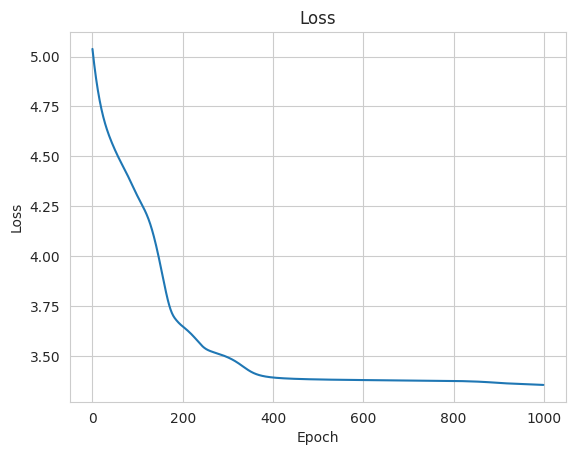

In [8]:
old_model = Einet(model_cfg)
train(old_data, old_model)